In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os
from IPython.display import Image

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [0]:
!pip install tensorboardX

    100% |████████████████████████████████| 133kB 4.7MB/s 


# Part 0 : Introduction to RNN and GRU

In [0]:
Image("RNN_Diagram.png")

One on the main drawback of FFNN is their lack of ability to manage sequential data since for this kind of model, the features are invariant par permutation . RNN address this issue by using a memory cell $h_t$ that is modified every time it sees a new input $x_t$ in order to produce a time-dependent output $y_t$. For instance, for an input sequence $(x_0,x_1,x_2)$, instead of having $y = FFNN( [x_0,x_1,x_2] )$, The RNN will behave as follow :

$y_1, h_1 = RNN(x_0)$ ;

$y_2, h_2 = RNN(x_1)$ ;

$y_3, h_3 = RNN(x_2)$ etc...

The $x_t$ can be words in a sentence for example


  
Mathematically, recurrent neural net can be written as:  

$H_t = \phi(U*X_t + W*H_{t-1})$

$y_t = \phi(V*H_{t})$

U: weight matrix associated to the $x_t$

W:  weight matrix associated to the  hidden layer

V: weight matrix associated to the output layer

The hidden state at time step t is $h_t$. It is a function of the input at the same time step $x_t$ and  the hidden state of the previous time step $ h_{t-1}$ The function  $\phi$ can be the sigmoid function($\sigma$) or tangent hyperbolic($tanh$)

$y_t$ represente the output at time step t

**Intuitively**, we as humans processes sequences in a similar way:

1)At each time step $t$, we update our memory (what we know) $h_t$ based on what we previously knew $h_{t-1}$ and the new information received $x_t$. Therefore, we can write $h_t = f(x_t, h_{t-1})$

2) The information that we output may not have the same structure / size as what is inside our memory : we transform the information in our memory to produce a desired output : $y_t = g(h_t)$

In RNN, for $f$ and $g$, we simply apply affine transformations to the inputs $x_t$ : $(U*X_t$), $h_{t-1}$ : ($W*H_{t-1}$) and $h_t$  : ($V*H_{t}$)to interpret them in a "convenient way" (w.r.t the task) and to make sure that dimensions are aligned before passing them to an activation function ($tanh$ or sigmoid)

###  Limitations of RNN:

During back propagation, recurrent neural networks suffer from the vanishing  gradient problem which means when we will update the model's parameters, the gradient will be very close to 0.

more about backpropagation and vanishing gradient: http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/,  https://medium.com/@anishsingh20/the-vanishing-gradient-problem-48ae7f501257


### GRU

GRU (Gated Recurrent Unit) aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. 

To solve that problem , GRU uses, so called, update gate and reset gate. Basically, these are two vectors which decide what information should be passed to the output.

## Update Gate:

$z_t = \sigma(W^{(z)}x_t + U^{(z)}h_{t-1})$

$x_t$:  current input

$W^{(z)}$ : weight associated to $x_t$

$h_{t-1}$ : output of the previous unit

$U^{(z)}$: weight associated to $h_{t-1}$

The update gate helps the model to determine how much of the past information  needs to be passed along to the future. 
Suppose we have: 
### 'Hello, my name is Jean  and I'm from France. I speak....'

To predict the next word we don't need to remember all the previous part. We can just use 'I'm from France' to now that the word to predict is 'French'. That's exactly what the update gate does, it allow the network to jus remember the usefull part to predict the next output.

That allows the model to decide to copy all the information from the past and eliminate the risk of vanishing gradient problem

## Reset Gate:

$r_t = \sigma(W^{(r)}x_t + U^{(r)}h_{t-1})$

this gate is used from the model to decide how much of the past information to forget. The difference  between Update Gate and Reset Gate comes in the weights and the gate’s usage.

Coming back to the example above the reset gate tell to the model you don't need to remember  'Hello, my name is Jean  and' to predict the next word.

## Current memory content

This will use the reset gate to store the relevant information from the past.

$h_{t}^{\prime} = \tanh(Wx_t +r_t ⊙  Uh_{t-1})$ 

$r_t ⊙  Uh_{t-1} $:  Hadamard (element-wise) product between the reset gate $r_t$ and $Uh_{t-1}$. That will determine what to remove from the previous time steps

$\tanh$: nonlinear activation function

## Final memory at current time step:

In this step the update gate is used.  It determines what to collect from the current memory content  $h_{t}^{\prime}$ and what from the previous steps  $ h_{t-1}$

$h_t = z_t  ⊙ h_{t-1} + (1-z_t)  ⊙ h_{t}^{\prime}$

* Apply element-wise multiplication to the update gate $z_t$ and $h_{t-1}$.
* Apply element-wise multiplication to $(1-z_t) $and $h_{t}^{\prime}$.
* Sum the two results 


Putting all in a graph GRU looks like the schema below:


more details [towardsdatascience](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be), [medium](https://medium.com/ai-journal/lstm-gru-recurrent-neural-networks-81fe2bcdf1f9), [karpathy blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

more references:

https://skymind.ai/wiki/lstm

https://medium.com/@carynmccarthy15/a-beginners-guide-to-recurrent-neural-networks-bfacb27bddb6

https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9

https://medium.com/@camrongodbout/recurrent-neural-networks-for-beginners-7aca4e933b82

http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/

https://towardsdatascience.com/what-is-a-recurrent-nns-and-gated-recurrent-unit-grus-ea71d2a05a69



# Part 1 : Question Answering with ParlAI

# Introduction to Question Answering 

![Question answering](https://github.com/AishaAlaagib/IndabaX-Rwanda/blob/master/fa4_fig01.jpg)

Search engines like Google and Yahoo! that allow the users to search for documents on the World
Wide Web. In Search engines the user has to check each and every document to get useful answer to the
question and it is a time consuming process. **The Question Answering (QA) system** reduces the search time toget exact answer to the question. Question Answering system is an important research area in information
retrieval. Research on the area of Question Answering system started in the year 1960 and present lot of
Question Answering systems have been developed. Question Answering system combines the research from
different domains like Natural Language Processing, Artificial Intelligence, Information Retrieval and
Information extraction.

**The objective** of question answering system is to find exact answer to the question asked
by user in natural language

To understand the Question Answering subject, we firstly define the associated terms. 

*   **A Question Phrase** is the part of the question that says what is searched.
*   ** Question Type**  refers to a categorization of the question for its purpose.
*   ** Answer Type** refers to a class of objects which are sought by the question. 
*    **Question Focus** is the property or entity being searched by the question. 
*   **Question Topic** is the object or event that the question is about. 
*  **Candidate Passage** can broadly be defined as anything from a sentence to a document retrieved by a search engine in response to a question. 
* ** Candidate Answer** is the text ranked according to its suitability to as an answer


But here we are not going to check all this details, in this case we just care about the  passage, question and answer because our data set contain a passages and  each passage is following by question and answer.

Generally, the question answering system can be
classified into two domains:
*  **Closed domain question answering system**

 It deals with questions under a specific
domain and can be seen as an easier task because NLP
systems can exploit domain-specific knowledge frequently
formalized in ontologies.  Alternatively, closed-domain might
refer to a situation where only a limited type of questions are
accepted, such as questions asking for descriptive rather
than procedural information.
* ** Open domain question answering system** 

 It is deals with questions about nearly anything, and
can only rely on general ontologies and world knowledge.

Closed domain question answering system give more exact and correct answer than the open domain question answering system.

# Exampe of Q/A:

These examples are from the dataset that will use throughout this tutorial :  **Babi tasks**

* Task 3 : Three supporting facts . Given a story, the model has to answer a question where only 3 sentences are useful (w.r.t the question)

**Task 3: Three Supporting Facts **  
John picked up the apple.  
John went to the office.  
John went to the kitchen.  
John dropped the apple.   
Where was the apple before the kitchen?  
**Answer: office**

* Task 2 : Two supporting facts . Given a story, the model has to answer a question where only 2 sentences are useful (w.r.t the question)

**Task 2: Two Supporting Facts**  
John is in the playground.  
John picked up the football.  
Bob went to the kitchen.  
Where is the football?  
**Answer: playground**




## References:

1. https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=11&cad=rja&uact=8&ved=2ahUKEwit9rWHls_hAhXKz4UKHUvWCscQFjAKegQIAxAB&url=https%3A%2F%2Fwww.researchgate.net%2Fpublication%2F320978810_An_Overview_of_Question_Answering_System&usg=AOvVaw01Y_S9X-3MXMpyrFg8mVqL
2. https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=13&cad=rja&uact=8&ved=2ahUKEwit9rWHls_hAhXKz4UKHUvWCscQFjAMegQIAhAB&url=https%3A%2F%2Fwww.ncbi.nlm.nih.gov%2Fpmc%2Farticles%2FPMC3825096%2F&usg=AOvVaw04BMj_m3ELsoau6ylXl6Pn


# ParlAI
[ParlAI](https://github.com/facebookresearch/ParlAI/blob/master/README.md) (pronounced “par-lay”) is a framework for dialogue AI research, implemented in Python.

Its goal is to provide researchers:

* a unified framework for sharing, training and testing dialogue models
* many popular datasets available all in one place -- from open-domain chitchat to visual question answering.
* a wide set of reference models -- from retrieval baselines to Transformers.
* seamless integration of Amazon Mechanical Turk for data collection and human evaluation
* integration with Facebook Messenger to connect agents with humans in a chat interface

Documentation can be found [here](http://www.parl.ai/static/docs/), some of this tutorial is inspired from the ParlAI documentation so feel free to go back and forth between the notebook and the documentation.


### Setup the notebook
If using google colab, make sure to use TPU runtime by going to ***Runtime > Change runtime type > Hardware accelerator: TPU > Save***

### Install ParlAI

Start by installing ParlAI from github. The ParlAI folder will be located in the home directory at `~/ParlAI/`.  
*Note: In a jupyter notebook, you can run arbitrary bash commands by prefixing them with a question mark, example: `!echo "Hello World"`*

In [0]:
# Remove `> /dev/null` to see the output of commands
!rm -fr ~/ParlAI
!git clone https://github.com/facebookresearch/ParlAI.git ~/ParlAI  > /dev/null
!cd ~/ParlAI; python setup.py develop > /dev/null

Cloning into '/root/ParlAI'...
remote: Enumerating objects: 20982, done.
remote: Total 20982 (delta 0), reused 0 (delta 0), pack-reused 20982
Receiving objects: 100% (20982/20982), 17.66 MiB | 30.40 MiB/s, done.
Resolving deltas: 100% (14598/14598), done.
zip_safe flag not set; analyzing archive contents...


Most of the scripts that we will use in ParlAI are located in the ~/ParlAI/examples directory.
Let's have a first glance at the scripts available, we will come back to them later:

In [0]:
!ls ~/ParlAI/examples/

base_train.py	       eval_model.py		 remote.py
build_dict.py	       extract_image_feature.py  seq2seq_train_babi.py
build_pytorch_data.py  interactive.py		 train_model.py
display_data.py        profile_train.py
display_model.py       README.md


## 1. Exploring the data

**First** we need to download the data, we will use the `build_dict.py` as a dummy task to download the data.

In [0]:
# Download the data silently
!python ~/ParlAI/examples/build_dict.py --task babi:task1k:1 --dict-file /tmp/babi1.dict > /dev/null
# Print a few examples
!head -n 30 ~/ParlAI/data/bAbI/tasks_1-20_v1-2/en-valid-10k-nosf/qa1_train.txt

Building dictionary: 100% 900/900 [00:00<00:00, 20.4kex/s]
1 Mary moved to the bathroom.
2 John went to the hallway.
3 Where is Mary? 	bathroom
4 Daniel went back to the hallway.
5 Sandra moved to the garden.
6 Where is Daniel? 	hallway
7 John moved to the office.
8 Sandra journeyed to the bathroom.
9 Where is Daniel? 	hallway
10 Mary moved to the hallway.
11 Daniel travelled to the office.
12 Where is Daniel? 	office
13 John went back to the garden.
14 John moved to the bedroom.
15 Where is Sandra? 	bathroom
1 Mary went to the bedroom.
2 John journeyed to the bathroom.
3 Where is John? 	bathroom
4 Sandra journeyed to the hallway.
5 John journeyed to the garden.
6 Where is Mary? 	bedroom
7 John journeyed to the bathroom.
8 Sandra journeyed to the garden.
9 Where is John? 	bathroom
10 Sandra went back to the bedroom.
11 Daniel travelled to the bathroom.
12 Where is John? 	bathroom
13 John went to the office.
14 Mary moved to the office.
15 Where is Sandra? 	bedroom


The bAbI tasks were downloaded in `~/ParlAI/data/bAbI/tasks_1-20_v1-2/en-valid-nosf/`

In bAbI the data is organised as follows:
- **Dialog turn**: A dialog turn is a single utterance / statement. Each line in the file corresponds to one dialog turn.   
  Example: *"John went to the office."*
- **Sample (question)**: Every few dialog turns, a question can be asked that the model has to answer, this consitute a sample.  The question is followed by its ground truth answer, separated by a tab.
  Example: *"Where is John? `<tab>` bathroom"*
- **Episode**: a sequence of ordered coherent dialog turns that are related to each other form an episode. Each new episode is independant of the others. Each line starts with the dialog turn number in the current episode.



## 3. Baseline

We now have a clearer idea of the data distribution and the metrics that we can use.  
The next step is to start solving the tasks with a simple baseline. This will allow us to compare more elaborate models agains this baseline.  
Here are a few classical baselines:
- **Random model**: The model answers randomly among the set of possible answers for each question
-  **Majority class**: The model always answers with the most frequent answer in the training set (majority class)

We are going to reimplement these own baselines.  
Implementing a new model in ParlAI is detailed in the [tutorial](http://parl.ai/static/docs/seq2seq_tutorial.html) but for our simple baselines, we will only need to inherit the [Agent](https://github.com/facebookresearch/ParlAI/blob/6d246842d3f4e941dd3806f3d9fa62f607d48f59/parlai/core/agents.py#L50) class and override the `act()` method.

---


---

*Note: the `%%writefile` magic command in jupyter writes the content of the cell to a file at the given path.*

In [0]:
!mkdir -p ~/ParlAI/parlai/agents/baseline/  ## create a folder to store our baseline files
!touch ~/ParlAI/parlai/agents/baseline/random.py ## create the random baseline file
!touch ~/ParlAI/parlai/agents/baseline/majorityclass.py ## create the majority baseline file

!mkdir -p ~/ParlAI/parlai/agents/rnn_model/    ## create a folder to store rnn model
!touch ~/ParlAI/parlai/agents/rnn_model/rnn_model.py ## create rnn model file

In [0]:
%%writefile ~/ParlAI/parlai/agents/baseline/random.py
import random

from parlai.core.torch_agent import Agent   ## import the Agent model where our baseline will inherit


class RandomAgent(Agent):
  
    def act(self):
        if 'label_candidates' not in self.observation:   ## check if the attribute label_candidates is part of oservation if not we will not do anything
            return
        candidates = list(self.observation['label_candidates'])  ## the candidates answer
        reply = {'text': candidates[random.randrange(len(candidates))]} ## choose randomly one of the candidate answer
        return reply  ## and return the choosen answer

Overwriting /root/ParlAI/parlai/agents/baseline/random.py


In [0]:
!python ~/ParlAI/examples/eval_model.py -t babi:task10k:1 -m baseline/random | grep accuracy

{'exs': 1000, 'accuracy': 0.162, 'f1': 0.162, 'bleu': 1.62e-10}


In [0]:
!python ~/ParlAI/examples/display_model.py -t babi:task10k:1 -m baseline/random -n 10 

[ optional arguments: ] 
[  display_ignore_fields:  ]
[  num_examples: 10 ]
[ Main ParlAI Arguments: ] 
[  batchsize: 1 ]
[  datapath: /root/ParlAI/data ]
[  datatype: valid ]
[  download_path: /root/ParlAI/downloads ]
[  hide_labels: False ]
[  image_mode: raw ]
[  multitask_weights: [1] ]
[  numthreads: 1 ]
[  show_advanced_args: False ]
[  task: babi:task10k:1 ]
[ ParlAI Model Arguments: ] 
[  dict_class: None ]
[  init_model: None ]
[  model: baseline/random ]
[  model_file: None ]
[ ParlAI Image Preprocessing Arguments: ] 
[  image_cropsize: 224 ]
[  image_size: 256 ]
[creating task(s): babi:task10k:1]
[loading fbdialog data:/root/ParlAI/data/bAbI/tasks_1-20_v1-2/en-valid-10k-nosf/qa1_valid.txt]
[babi:task10k:1]: Sandra travelled to the office.
Sandra went to the bathroom.
Where is Sandra?
[label_candidates: garden|bedroom|bathroom|office|hallway|...and 1 more]
[eval_labels: bathroom]
   kitchen
~~
[babi:task10k:1]: Mary went to the bedroom.
Daniel moved to the hallway.
Where is S

In [0]:
%%writefile ~/ParlAI/parlai/agents/baseline/majorityclass.py
import random

from parlai.core.torch_agent import Agent


class MajorityclassAgent(Agent):
  
    def act(self):
        # From the previous answers:
        # Possible answers: Counter({'bathroom': 1564, 'hallway': 1517, 'garden': 1508, 'bedroom': 1473, 'kitchen': 1471, 'office': 1467}) (6)
        # So the most common answer is 'bathroom'
        reply = {'text': 'bathroom'}
        return reply

Overwriting /root/ParlAI/parlai/agents/baseline/majorityclass.py


In [0]:
!python ~/ParlAI/examples/eval_model.py -t babi:task10k:1 -m baseline/majorityclass | grep accuracy

{'exs': 1000, 'accuracy': 0.169, 'f1': 0.169, 'bleu': 1.69e-10}


In [0]:
!python ~/ParlAI/examples/display_model.py -t babi:task10k:1 -m baseline/majorityclass -n 10

[ optional arguments: ] 
[  display_ignore_fields:  ]
[  num_examples: 10 ]
[ Main ParlAI Arguments: ] 
[  batchsize: 1 ]
[  datapath: /root/ParlAI/data ]
[  datatype: valid ]
[  download_path: /root/ParlAI/downloads ]
[  hide_labels: False ]
[  image_mode: raw ]
[  multitask_weights: [1] ]
[  numthreads: 1 ]
[  show_advanced_args: False ]
[  task: babi:task10k:1 ]
[ ParlAI Model Arguments: ] 
[  dict_class: None ]
[  init_model: None ]
[  model: baseline/majorityclass ]
[  model_file: None ]
[ ParlAI Image Preprocessing Arguments: ] 
[  image_cropsize: 224 ]
[  image_size: 256 ]
[creating task(s): babi:task10k:1]
[loading fbdialog data:/root/ParlAI/data/bAbI/tasks_1-20_v1-2/en-valid-10k-nosf/qa1_valid.txt]
[babi:task10k:1]: Sandra travelled to the office.
Sandra went to the bathroom.
Where is Sandra?
[eval_labels: bathroom]
[label_candidates: bedroom|kitchen|office|garden|hallway|...and 1 more]
   bathroom
~~
[babi:task10k:1]: Mary went to the bedroom.
Daniel moved to the hallway.
Whe

# 4 : Our RNN Model

Now it is time to create and train our very own model for Question Answering !

In order to to so, we will create a class called **RnnModelAgent** that will represent our model in ParlAI and will use a GRU to make the predictions.

Our GRU model is made of the following:

1) An **Embedding layer** : it is simply a lookup table that given a token index (for example 24 for the word "bathroom") will return the corresponding word vector of dimension *hidden_size*. The number of rows in this layer will be equal to the number of words in our dictionnary (since for each of them it has to provide a dense representation : the word  vector)

2) A **GRU layer** as explained in Section 0

3) A **Decoder** that will transform the output of the GRU into a vector of score for each word of the dictionnary. The higher the score for a word, the most likely this word is the correct answer to the question (according to the model)

A ParlAI agent has to implement 3 main methods:

1) **__init__**  where we will initialize our model, define useful constants and create the optimizer

2) **train_step** : it is the core of our agent. Given a batch of input (stories, questions and answers), we will write the code that compute the model's prediction, the loss of this prediction and apply the backpropagation algorithm on the loss using the optimizer

3) **eval_step** : Given a batch of stories and questions (notice that answers are not provided since it is the *evaluation* phase), we will write the code that will output the model's predictions

In [0]:

%%writefile ~/ParlAI/parlai/agents/rnn_model/rnn_model.py
##import parlai and pytorch
from parlai.core.torch_agent import TorchAgent, Output
from parlai.core.utils import padded_3d
from parlai.core.logs import TensorboardLogger

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from tensorboardX import SummaryWriter

losses = []
##define the model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size ## input of the model: number of characters in our dictionary
        self.hidden_size = hidden_size ## number of neurons per layers
        self.output_size = output_size ## output size of the model: number of charaters in the output
        self.n_layers = n_layers  ## number of layers of the model
        
        self.encoder = nn.Embedding(input_size, hidden_size)## map a characters to a fixed size of vector (for characters embeddings)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers) ## define the GRU part:it takes asinput the embedding vectors from the encoder
        self.decoder = nn.Linear(hidden_size, output_size) ## decode the vectors output of the GRU to characters 
    
    def forward(self, input, hidden): 
        input = self.encoder(input)
        output, hidden = self.gru(input, hidden)
        output = self.decoder(output)
        output = F.log_softmax(output, dim=1)
        return output, hidden

    def init_hidden(self, batch_size=32):
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)) ##initialize all the hidden state to zero

class RnnModelAgent(TorchAgent):
    
    @staticmethod    
    def add_cmdline_args(argparser):  ## to allow to run the model on command line
        agent = argparser.add_argument_group("Simple RNN Arguments")
        
        agent.add_argument("-hs", "--hidden-size", type=int, default=128, help="Size of the hidden layer(s) of the RNN")
        agent.add_argument("-nl", "--num-layers", type=int, default=1, help="Number of layers of the RNN")
        
        TorchAgent.add_cmdline_args(argparser)
        RnnModelAgent.dictionary_class().add_cmdline_args(argparser)
        
        return agent
    
    def __init__(self, opt, shared=None):
        
        super().__init__(opt, shared)
        
        if opt['tensorboard_log'] is True:
            self.writer = TensorboardLogger(opt)
        
        self.dictionnary_size = 26      ## we suppose that our dictionary contain the 26 characters of the alphabet
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  
        self.use_cuda = True if torch.cuda.is_available() else False
        self.embedding_dim = opt["hidden_size"]  ##the dimension of our embemding vector after transforming the character to a vector
        self.n_layers = opt["num_layers"]  ## number of layer of the network
        self.batch_size = opt["batchsize"]  ## number of examples that we are going to pass as an input at the same time to the network
        self.criterion = nn.NLLLoss()  ### define the loss of our network
        print("Init called!")
          
        if (shared is not None) and ("decoder" in shared):
          self.decoder = shared["decoder"]
          print("Shared")
          
        else:
          self.decoder = RNN(self.dictionnary_size, self.embedding_dim, self.dictionnary_size, self.n_layers) ## This RNN refer to the previous RNN class
          print("Not shared")
          
          
        self.decoder.to(self.device)
        self.model = self.decoder
        
        def weight_init(m):   ##initialisation of the weights of our model using xavier
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
        
        self.decoder.apply(weight_init)    #apply the initialized weight to the model
        self.optimizer = optim.Adam(self.decoder.parameters()) ## use Adam optimizer for the model to perform backpropagation(weight updating)
        self.scheduler = None
        self.warmup_scheduler = None
        self.batch_iter = 0

        
        
    def vectorize(self, *args, **kwargs):    ## this function is called by parlai to preprocess text
        """Override options in vectorize from parent."""
        kwargs['add_start'] = False       ##to avoid starting at  the start of sentence
        kwargs['add_end'] = False
        return super().vectorize(*args, **kwargs)
      
      
    ## the next function allows us to train the model we defined so far
    def train_step(self, batch):  
        
        self.decoder.train()
        
        contexts, answers = batch.text_vec, batch.label_vec # extract the different contexts and answers from the batch input
        
        self.optimizer.zero_grad() ## Since the backward() function accumulates gradients, and we don’t want to mix up gradients between minibatches,
                                   ## we have to zero them out at the start of a new minibatch

        loss = 0
        hidden = self.decoder.init_hidden(self.batch_size).to(self.device) ## initialize the hidden state to zero by calling the previous init_hidden function

        output, hidden = self.decoder(contexts.t(), hidden) 
        output = output.transpose(0,1)[:,-1,:]              ## to get sequence leng, batch, dimension
        loss += self.criterion(output.squeeze(1), answers.squeeze(1)) ## compute the loss by comparing the output of our model and the true answer
            
        
        pred = output.argmax(dim=1)  ## get the predicted answer of our model: it appear at the index which has the bigger value of probbility
        
        losses.append(loss.item())  ## accumulate the loss
         
        loss.backward() ## backpropagate the loss to update the parameters of the model
        self.optimizer.step()  #specify that we finish with one step optimization 
        
        self.batch_iter+= 1 ## next iteration
        
        return Output(self.dict.vec2txt(pred).split(" ")) # convert the vector output to text and return it
    
    def eval_step(self, batch): #after training the model we need to evaluate it in order to measure its performance
      
        self.decoder.eval()
        
        contexts = batch.text_vec ## in the evaluation case we don't have acces to an asnwer, the only thing we have is the question
        
        hidden = self.decoder.init_hidden(contexts.shape[0]).to(self.device) ## as usually we initialize the hidden state

        output, hidden = self.decoder(contexts.t(), hidden)  # compute the output of the model on unseen data
        output = output.transpose(0,1)[:,-1,:]    ## to get sequence leng, batch, dimension
            
        
        pred = output.argmax(dim=1)  # get the predicte
        
        #print("Batch keys : ", batch.keys())
        #print("Pred shape : ", pred.shape)
        #print("Text vec : ", batch.text_vec.shape)
        #print("Predictions : ", pred.shape)
        
        #print(self.decoder.gru.weight_hh_l0.data)
        
        return Output(self.dict.vec2txt(pred).split(" "))
    
    

Overwriting /root/ParlAI/parlai/agents/rnn_model/rnn_model.py


In [0]:
#!rm -fr /tmp/*
!ls /tmp/

babi1.dict	       my_rnn_model.test	seq2seq_model.opt
babi1.dict.opt	       my_rnn_model.trainstats	seq2seq_model.test
my_rnn_model	       my_rnn_model.valid	seq2seq_model.trainstats
my_rnn_model.dict      seq2seq_model		seq2seq_model.valid
my_rnn_model.dict.opt  seq2seq_model.dict
my_rnn_model.opt       seq2seq_model.dict.opt


In [0]:
!rm -fr /tmp/my_rnn_model*
!python ~/ParlAI/examples/train_model.py -t babi:task10k:1 -bs 32 -eps 10 -m rnn_model -mf /tmp/my_rnn_model --dict-file /tmp/babi1.dict

[ Main ParlAI Arguments: ] 
[  batchsize: 32 ]
[  datapath: /root/ParlAI/data ]
[  datatype: train ]
[  download_path: /root/ParlAI/downloads ]
[  hide_labels: False ]
[  image_mode: raw ]
[  multitask_weights: [1] ]
[  numthreads: 1 ]
[  show_advanced_args: False ]
[  task: babi:task10k:1 ]
[ ParlAI Model Arguments: ] 
[  dict_class: parlai.core.dict:DictionaryAgent ]
[  init_model: None ]
[  model: rnn_model ]
[  model_file: /tmp/my_rnn_model ]
[ Training Loop Arguments: ] 
[  dict_build_first: True ]
[  display_examples: False ]
[  eval_batchsize: None ]
[  evaltask: None ]
[  load_from_checkpoint: False ]
[  max_train_time: -1 ]
[  num_epochs: 10.0 ]
[  save_after_valid: False ]
[  save_every_n_secs: -1 ]
[  short_final_eval: False ]
[  validation_cutoff: 1.0 ]
[  validation_every_n_epochs: -1 ]
[  validation_every_n_secs: -1 ]
[  validation_max_exs: -1 ]
[  validation_metric: accuracy ]
[  validation_metric_mode: None ]
[  validation_patience: 10 ]
[  validation_share_agent: False

In [0]:
!python ~/ParlAI/examples/eval_model.py -mf /tmp/my_rnn_model -t babi:task10k:1 -dt valid --dict-file /tmp/babi1.dict

[ warning: overriding opt['datatype'] to valid (previously: train )]
Dictionary: loading dictionary from /tmp/babi1.dict
[ num words =  26 ]
[ Using CUDA ]
Init called!
Not shared
[creating task(s): babi:task10k:1]
[loading fbdialog data:/root/ParlAI/data/bAbI/tasks_1-20_v1-2/en-valid-10k-nosf/qa1_valid.txt]
[ optional arguments: ] 
[  display_examples: False ]
[  log_every_n_secs: 2 ]
[  metrics: all ]
[  num_examples: -1 ]
[ Main ParlAI Arguments: ] 
[  batchsize: 32 ]
[  datapath: /root/ParlAI/data ]
[  datatype: valid ]
[  download_path: /root/ParlAI/downloads ]
[  hide_labels: False ]
[  image_mode: raw ]
[  multitask_weights: [1] ]
[  numthreads: 1 ]
[  show_advanced_args: False ]
[  task: babi:task10k:1 ]
[ ParlAI Model Arguments: ] 
[  dict_class: parlai.core.dict:DictionaryAgent ]
[  init_model: None ]
[  model: rnn_model ]
[  model_file: /tmp/my_rnn_model ]
[ PytorchData Arguments: ] 
[  batch_length_range: 5 ]
[  batch_sort_cache_type: pop ]
[  batch_sort_field: text ]
[  nu

In [0]:
!rm -fr /tmp/seq2seq_model*
!python ~/ParlAI/examples/train_model.py -t babi:task10k:1 -bs 32 -eps 10 -m seq2seq -mf /tmp/seq2seq_model --dict-file /tmp/babi1.dict

[ Main ParlAI Arguments: ] 
[  batchsize: 32 ]
[  datapath: /root/ParlAI/data ]
[  datatype: train ]
[  download_path: /root/ParlAI/downloads ]
[  hide_labels: False ]
[  image_mode: raw ]
[  multitask_weights: [1] ]
[  numthreads: 1 ]
[  show_advanced_args: False ]
[  task: babi:task10k:1 ]
[ ParlAI Model Arguments: ] 
[  dict_class: parlai.core.dict:DictionaryAgent ]
[  init_model: None ]
[  model: seq2seq ]
[  model_file: /tmp/seq2seq_model ]
[ Training Loop Arguments: ] 
[  dict_build_first: True ]
[  display_examples: False ]
[  eval_batchsize: None ]
[  evaltask: None ]
[  load_from_checkpoint: False ]
[  max_train_time: -1 ]
[  num_epochs: 10.0 ]
[  save_after_valid: False ]
[  save_every_n_secs: -1 ]
[  short_final_eval: False ]
[  validation_cutoff: 1.0 ]
[  validation_every_n_epochs: -1 ]
[  validation_every_n_secs: -1 ]
[  validation_max_exs: -1 ]
[  validation_metric: accuracy ]
[  validation_metric_mode: None ]
[  validation_patience: 10 ]
[  validation_share_agent: False 

In [0]:
!python ~/ParlAI/examples/eval_model.py -mf /tmp/seq2seq_model -t babi:task10k:1 -dt valid -bs 32 --dict-file /tmp/babi1.dict

[ warning: overriding opt['datatype'] to valid (previously: train )]
Dictionary: loading dictionary from /tmp/seq2seq_model.dict
[ num words =  26 ]
[ Using CUDA ]
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
[ Loading existing model params from /tmp/seq2seq_model ]
[creating task(s): babi:task10k:1]
[loading fbdialog data:/root/ParlAI/data/bAbI/tasks_1-20_v1-2/en-valid-10k-nosf/qa1_valid.txt]
[ optional arguments: ] 
[  display_examples: False ]
[  log_every_n_secs: 2 ]
[  metrics: all ]
[  num_examples: -1 ]
[ Main ParlAI Arguments: ] 
[  batchsize: 32 ]
[  datapath: /root/ParlAI/data ]
[  datatype: valid ]
[  download_path: /root/ParlAI/downloads ]
[  hide_labels: False ]
[  image_mode: raw ]
[  multitask_weights: [1] ]
[  numthreads: 1 ]
[  show_advanced_args: False ]
[  task: babi:task10k:1 ]
[ ParlAI Model Arguments: ] 
[  dic

In [0]:
!cat /root/ParlAI/parlai/agents/example_seq2seq/example_seq2seq.py

#!/usr/bin/env python3

# Copyright (c) Facebook, Inc. and its affiliates.
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.
"""Example sequence to sequence agent for ParlAI "Creating an Agent" tutorial.
http://parl.ai/static/docs/tutorial_seq2seq.html
"""

from parlai.core.torch_agent import TorchAgent, Output

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F


class EncoderRNN(nn.Module):
    """Encodes the input context."""

    def __init__(self, input_size, hidden_size, numlayers):
        """Initialize encoder.

        :param input_size: size of embedding
        :param hidden_size: size of GRU hidden layers
        :param numlayers: number of GRU layers
        """
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=numlayers

In [0]:
cp /root/ParlAI/parlai/agents/example_seq2seq/__init__.py /root/ParlAI/parlai/agents/rnn_model/

In [0]:
!ls /root/ParlAI/parlai/agents/rnn_model/

__init__.py  __pycache__  rnn_model.py


In [0]:
!python ~/ParlAI/examples/interactive.py -mf /tmp/my_rnn_model

[ optional arguments: ] 
[  display_examples: False ]
[  display_ignore_fields: label_candidates,text_candidates ]
[  display_prettify: False ]
[ Main ParlAI Arguments: ] 
[  batchsize: 1 ]
[  datapath: /root/ParlAI/data ]
[  datatype: train ]
[  download_path: /root/ParlAI/downloads ]
[  hide_labels: False ]
[  image_mode: raw ]
[  multitask_weights: [1] ]
[  numthreads: 1 ]
[  show_advanced_args: False ]
[  task: None ]
[ ParlAI Model Arguments: ] 
[  dict_class: parlai.core.dict:DictionaryAgent ]
[  init_model: None ]
[  model: None ]
[  model_file: /tmp/my_rnn_model ]
[ Local Human Arguments: ] 
[  local_human_candidates_file: None ]
[  single_turn: False ]
[ ParlAI Image Preprocessing Arguments: ] 
[  image_cropsize: 224 ]
[  image_size: 256 ]
[ Simple RNN Arguments: ] 
[  hidden_size: 128 ]
[  num_layers: 1 ]
[ TorchAgent Arguments: ] 
[  add_p1_after_newln: False ]
[  betas: (0.9, 0.999) ]
[  delimiter: 
 ]
[  embedding_projection: random ]
[  embedding_type: random ]
[  fp16: F

# Part 2 (Optional) : Language Modeling

Language is a method of human communication, either spoken or written, consisting of the use of words in a structured and conventional way. In Natural Language Processing, the set of words used is represented using text. In this section we will define what we understand by text, why language modelling (LM) is useful and give some applications of LM :


**A text** is a sequence of token. Tokens can be words, characters or group of characters.


 A word is a meaningful sequence of charaters.
 
 Example :
                                      
    {INDABAX RWANDA} = {IN, DA, BAX,  RWAN, DA}
 
                     = {INDABAX,  , RWANDA}
                                              
                     ={I, N, D, A, B, A, X,  , R, W, A, N, D, A}
  ----------------

**Language modelling**  is a subfield of NLP which goal is to design methods to assign a probability to a text (sequence of tokens) .
To illiustrate it , suppose you have a sequence of tokens $(x_1, x_2, x_3, ..., x_n)$, language model estimate probability of this tokens.

$$ P(x_1, x_2, x_3, ..., x_n) $$

This probability depends of a **vocabulary** which is a set of unique tokens.

Let's take an example:
We want to determine a probability of a sentence. We can tokenize it as  sequence of words $(x_1, x_2, x_3, ..., x_t)$
We can calculate the probability by using the "Chain rule of Probability":

$ P(x_1, x_2, x_3, ..., x_r)= \prod_{t=1} ^{r} P(x_t|x_{t-1}, x_{t-2}, ..., x_{1})  $

There exists many ways to coumpute probability,
it can be done by counting the number of times a sequence of tokens occurs in the dataset, this method is called **Count based language model**

Example of dataset:

1: 'I am very happy to assist to INDABAX RWANDA '
2: ' I am at Kigali Rwanda' 
3: 'I am really enjoy this summer school'
$P( \text{Rwanda} | \text{I am at Kigali } ) = \frac{c(\text{I am at Kigali } )}{c( \text{RWANDA})} =  1/2$

One limitation of this method appears when we want to model long sentences. In general, the longer the sentence, the lower its probability : it is more likely to see a sequence of tokens like

A:  "I am at Kigali" in a dataset than

B:  " am at Kigali eating an ice cream at an Italian restauranIt called Sole Lunda somewhere in Remera because I love italian ice cream". 

With respect to our previously defined dataset, sequence B is unkwown (since it doesn't appear in the dataset) and the conditional probabilities are as well unknown (We cannot estimate the probability of "Luna" given ""I am at Kigali eating an ice cream at an Italian restauranIt called Sole" based on our dataset)

To fix  this issue we truncate past to a fixed size window of size $n$ i.e.:

$ P(x_1, x_2, x_3, ..., x_r)= \prod_{t=1} ^{r} P(x_t|x_{t-1}, x_{t-2}, ..., x_{1})  \approx \prod_{t=1} ^{r} P(x_t|x_{t-1}, x_{t-2}, ..., x_{t-n})$

this method is call **n-gram model**

As we said earlier, ** "n” ** refers to the size of past

- Examples:
   - Unigram:
   
       $ P(w_1 , . . . , w_T ) =\prod_{t=1} ^{T}  P(w_t )$
   - Bigram:
   
     $ P(w_1 , . . . , w_T ) =\prod_{t=1} ^{T}  P(w_t | w_{t−1} )$
   - Trigram:
   
   $   P(w_1 , . . . , w_T ) =\prod_{t=1} ^{T}  P(w_t | w_{t−1},  w_{t−2})$
   
n-grams can be “good enough” in some cases but n-grams cannot capture long term dependencies required
to truely model language.
Various methods have been developed to overcume this issues. Among them we can **Backoff** and **Interpolation**

[more info](http://www.cs.cornell.edu/courses/cs4740/2014sp/lectures/smoothing+backoff.pdf)


------------

**Application**

- Speech recognition 

It is  a subfield of Machine Learning where we want to give the ability to a machine to convert spoken language into text. In real life, some sentences may have the same pronunciation : For example, "Chocolate, I scream" and "Chocolate ice scream" or ""Eye eight uh Jerry" and "”I ate a cherry"". As humans, in a real conversation, we know that the first sentences are more plausible than the seconds:

 1) P(”Chocolate, I scream”) < P(”Chocolate ice cream”)
  
 2) P(”Eye eight uh Jerry") < P(”I ate a cherry")
  
  A machine can acquire this kind of commonsense using an accurate language model that will give it the probabilities of both sentences in order to choose the most likely one
- Machine translation

 It is the process by which a computer software is used to translate a text from one natural language (such as English) to target language (such as French, Kinyrwanda)
[more info](https://www.aclweb.org/anthology/D07-1090.pdf). Given a sentence in the source language, we want to know the most probable sentence in a target language such that they have the same meaning. However, multiple sentences in the target language can be grammaticaly correct and have approximately the same meaning as the one in the source language. For example

In French "Jane visite l'Afrique en Septembre"

In English:

1) Jane is visiting Africa in September.

2) Jane is going to be visiting Africa in September.

3) In September, Jane will visit Africa.

4) Her African friend welcomed Jane in September.

How can a computer choose the correct one ? By using a language model ! As good english speakers, we know that the first translation is more likely than the forth one in this case. A good language model will give the same result
  
- Optical Character Recognition & Handwriting recognition

Optical character recognition is the recognition of printed or written text characters by a computer. This involves photoscanning of the text character-by-character, analysis of the scanned-in image, and then translation of the character image into character codes, such as ASCII, commonly used in data processing.
[more info](https://www.youtube.com/watch?v=ZNrteLp_SvY)

Again, language models are used to disentangle ambiguities : for example, sometimes it's difficult to see the difference between 0 (zero) and O (the letter) on a handwritten document. A computer can easily confuse "m0ve fast" and "move fast" and humans too! But as humans we know that the second one is more likely than the first one : 

  P(”m0ve fast”) < P(”move fast”)
  
 A good language model will give the ability to the computer to output the right sentence
 
- Context sensitive spelling correction

It is the task of correcting spelling errors which results in valid words. Our smartphones heavily use language models to do so.

Example :

  "Their are problems wit this sentence" -> "There are problems with this sentence"

**Deep learning for Language Modelling**

We know that Deep Learning can be very successful for classification and probability estimation. And as we saw earlier, Language modelling is just conditional probability estimation ! Instead of using n-grams and co., can we replace it by a neural network that will take as input the sequence  $x_{t-1}, x_{t-2}, ..., x_{t-n}$ and output $P(x_t|x_{t-1}, x_{t-2}, ..., x_{t-n})$ ? Yes! And fortunately we have a lot of texts available on Internet i.e. a lot of training data !

## Implementation of the RNN Language Model

Our goal here is to produce a language model based on Shakespear books : after the training, our model is expect to produce sequences of characters that have a similar style as Shakespear work

In [0]:
!wget https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt
!ls

--2019-04-13 11:54:24--  https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4573338 (4.4M) [text/plain]
Saving to: ‘shakespeare_input.txt’

shakespeare_input.t 100%[===================>]   4.36M  7.59MB/s    in 0.6s    

2019-04-13 11:54:25 (7.59 MB/s) - ‘shakespeare_input.txt’ saved [4573338/4573338]

sample_data  shakespeare_input.txt


In [0]:
!pip install unidecode

    100% |████████████████████████████████| 245kB 6.4MB/s 


We start by reading the input file and define the set of valid characters

In [0]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('shakespeare_input.txt').read())
file_len = len(file)
print('file_len =', file_len)
print("n_characters : ", n_characters)

file_len = 4573338
n_characters :  100


Since we will do mini-batch training, we have to create a function that will extract a "batch" i.e. a piece of text from our dataset:

In [0]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

ysician;
His antidotes are poison, and he slays
Moe than you rob: take wealth and lives together;
Do villany, do, since you protest to do't,
Like workmen. I'll example you with thievery.
The sun's a th


Then it is time to create our model : we will use the exact same model as in the previous section (QA)

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        output = F.log_softmax(output, dim=1)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))


We know that our model only understand numbers. We therefore have to convert each character to a fixed number or more generally, a sequence of characters (a string) into a list of numbers

In [0]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Based on random_chunk, we have to write a function that will extract a mini-batch:

In [0]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

This is a code spinnet to evaluate our model assuming that the first characters are "*prime_str*"

In [0]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden().to(device)
    prime_input = char_tensor(prime_str).to(device)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1].to(device)    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char).to(device)

    return predicted

In [0]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
def train(inp, target):
    hidden = decoder.init_hidden().to(device)
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].reshape(-1))

    loss.backward()
    decoder_optimizer.step()

    return loss.data / chunk_len

In [0]:
n_epochs = 10000
print_every = 100
plot_every = 10
hidden_size = 128
n_layers = 3
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder.to(device)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.NLLLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
  inputs, labels = random_training_set()
  inputs, labels = inputs.to(device), labels.to(device)
  loss = train(inputs, labels)       
  loss_avg += loss

  if epoch % print_every == 0:
    print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
    print(evaluate('Wh', 100), '\n')

  if epoch % plot_every == 0:
    all_losses.append(loss_avg / plot_every)
    loss_avg = 0

 34s (100 1%) 2.4968]
Whean
Beusn,
Thum heroy nerekal bann thoun mereanswivhalet can coursde thinnd sit fhabs won! me bnin!  

 8s (200 2%) 2.3825]
Whams thew the rase thjy mades thesterle nakes waI ciicrucs baves, hy
chest maltes? ath onhs maenild t 

 42s (300 3%) 2.0130]
What, her is the wan wee thee. Sor hofs siive.

FEM:
In to to me it the net to of so in the, epre the  

 17s (400 4%) 2.0316]
Whis sher Anlighth do highitth for teav
That be drake sas mand hin me way a frows teat, the she of war 

 51s (500 5%) 2.3362]
Wher a wave are comzanss.

BFId sarse that haes, doth.

Furrer your mang:
Lathou morks your leark, Fro 

 26s (600 6%) 2.0570]
Whis theed fable sursers of this sorn of to uch
tor ploness thubere
hould for bould worgerarang toor n 



KeyboardInterrupt: ignored

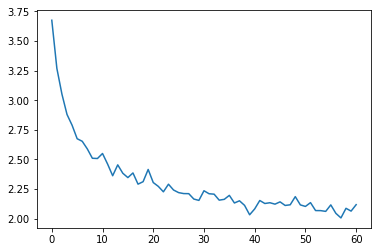

In [0]:
 import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [0]:
print(evaluate('Th', 200, temperature=0.8))

The carses; and vator't,
And it loldine: torile's and him and fortone-doodoss that is
Thou come I trone, and indinderenes hoth porn to arn mine.

ALGUDIMY ONOTE:
Covee plat!

RITO
And to to that my my k


In [0]:
print(evaluate('Th', 200, temperature=0.2))

The mand the mare the mand the mand the rise to songer the come to doth the doth in to songer the the the may the the come to songer the come to songer the the the come.

IOLIO:
I and so so in the mand 


In [0]:
print(evaluate('Th', 200, temperature=1.4))

Thall tade vOnquarge!wo,
Theyousgy. I do qundale, it lither
Dowhcm extaje i greplyall.
Gowoa tal tished isastierim.
'Ote, on tunkerex, s.
It my your, you wrostiever,
And a mist, nless, anl is let'this J
